In [30]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [31]:
config = {
    'batch_size': 64,
    'learning_rate': 0.005,
    'epochs': 10,
    'device': 'mps',
    'data_dir': 'data/',
    'log_dir': 'runs/experiment1'
}

DEVICE = config['device']

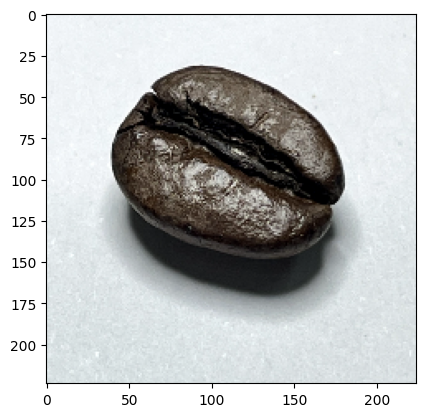

In [32]:
img = io.read_image('/Users/violettabahareva/ds-phase-2/08-nn/data/coffee-beans/test/Dark/dark (100).png')

plt.imshow(torch.permute(img, (1, 2, 0)))

In [33]:
temp_trnsfrm = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

temp_dataset = torchvision.datasets.ImageFolder('/Users/violettabahareva/ds-phase-2/08-nn/data/coffee-beans/test', transform=temp_trnsfrm)
temp_loader = DataLoader(temp_dataset, batch_size=config['batch_size'], shuffle=False)

import torch

def compute_mean_std(loader):
    """Вычисляет mean и std по датасету."""
    mean = torch.zeros(3)  # [0, 0, 0] — для RGB
    std = torch.zeros(3)
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)  # [B, C, H*W]
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

mean, std = compute_mean_std(temp_loader)
print(f"Mean: {mean}")
print(f"Std:  {std}")

Mean: tensor([0.7167, 0.7088, 0.6765])
Std:  tensor([0.2253, 0.2531, 0.2972])


In [34]:
tr_trnsfrms = T.Compose(
        [
            T.Resize((244, 244)),
            T.RandomRotation(45),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize(
                (.5, .5, .5), (.5, .5, .5) # нормализация
            )
        ]
    )

val_trnsfrms = T.Compose(
        [
            T.Resize((244, 244)),
            T.ToTensor(),
            T.Normalize(
                (.5, .5, .5), (.5, .5, .5) # нормализация
            )
        ]
    )

In [35]:
train_aug_dataset = torchvision.datasets.ImageFolder('/Users/violettabahareva/ds-phase-2/08-nn/data/coffee-beans/train',
                                                 transform=tr_trnsfrms)
valid_aug_dataset = torchvision.datasets.ImageFolder('/Users/violettabahareva/ds-phase-2/08-nn/data/coffee-beans/test',
                                                 transform=val_trnsfrms)

In [36]:
train_aug_dataset

Dataset ImageFolder
    Number of datapoints: 1200
    Root location: /Users/violettabahareva/ds-phase-2/08-nn/data/coffee-beans/train
    StandardTransform
Transform: Compose(
               Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [37]:
train_loader = DataLoader(train_aug_dataset, batch_size=config['batch_size'], shuffle=True)
valid_loader = DataLoader(valid_aug_dataset, batch_size=config['batch_size'], shuffle=True)

train_loader

In [38]:
import torchvision.models as models

model = models.shufflenet_v2_x1_0(pretrained=True).to(DEVICE)

In [39]:
model

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [40]:
num_classes = 4
model.fc = nn.Linear(in_features=1024, out_features=num_classes)
model.fc

Linear(in_features=1024, out_features=4, bias=True)

In [41]:
for param in model.parameters():
    param.requires_grad = False

model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

model.to(DEVICE)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [42]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [43]:
model = model.to(DEVICE)
tu.get_model_summary(model, torch.randn(32, 3, 224, 224, device=DEVICE))

Layer                                     Kernel               Output         Params          FLOPs
0_conv1.Conv2d_0                         [3, 24, 3, 3]   [32, 24, 112, 112]       648   260,112,384
1_conv1.BatchNorm2d_1                             [24]   [32, 24, 112, 112]        48    38,535,168
2_conv1.ReLU_2                                       -   [32, 24, 112, 112]         0             0
3_maxpool                                            -     [32, 24, 56, 56]         0             0
4_stage2.0.branch1.Conv2d_0              [1, 24, 3, 3]     [32, 24, 28, 28]       216     5,419,008
5_stage2.0.branch1.BatchNorm2d_1                  [24]     [32, 24, 28, 28]        48     2,408,448
6_stage2.0.branch1.Conv2d_2             [24, 58, 1, 1]     [32, 58, 28, 28]     1,392    34,922,496
7_stage2.0.branch1.BatchNorm2d_3                  [58]     [32, 58, 28, 28]       116     5,820,416
8_stage2.0.branch1.ReLU_4                            -     [32, 58, 28, 28]         0             0


In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=config['learning_rate'])

In [45]:
def compute_batch_accuracy(preds, labels):
    """
    Вычисляет точность для многоклассовой классификации.

    preds: torch.Tensor, shape (B, num_classes) — логиты модели
    labels: torch.Tensor, shape (B,) — истинные метки (long)
    """
    predicted_classes = preds.argmax(dim=1)           # (B,)
    correct = (predicted_classes == labels).sum()     # скаляр
    accuracy = correct.float() / labels.size(0)       # доля правильных
    return accuracy.item()

[Epoch 00] Train loss: 1.2666, valid loss = 1.2313 Train acc 0.7023 Valid acc 0.7746
[Epoch 01] Train loss: 1.0428, valid loss = 1.0458 Train acc 0.9446 Valid acc 0.8504
[Epoch 02] Train loss: 0.8739, valid loss = 0.8870 Train acc 0.9433 Valid acc 0.9464
[Epoch 03] Train loss: 0.7469, valid loss = 0.7688 Train acc 0.9518 Valid acc 0.9665
[Epoch 04] Train loss: 0.6386, valid loss = 0.6890 Train acc 0.9655 Valid acc 0.9598


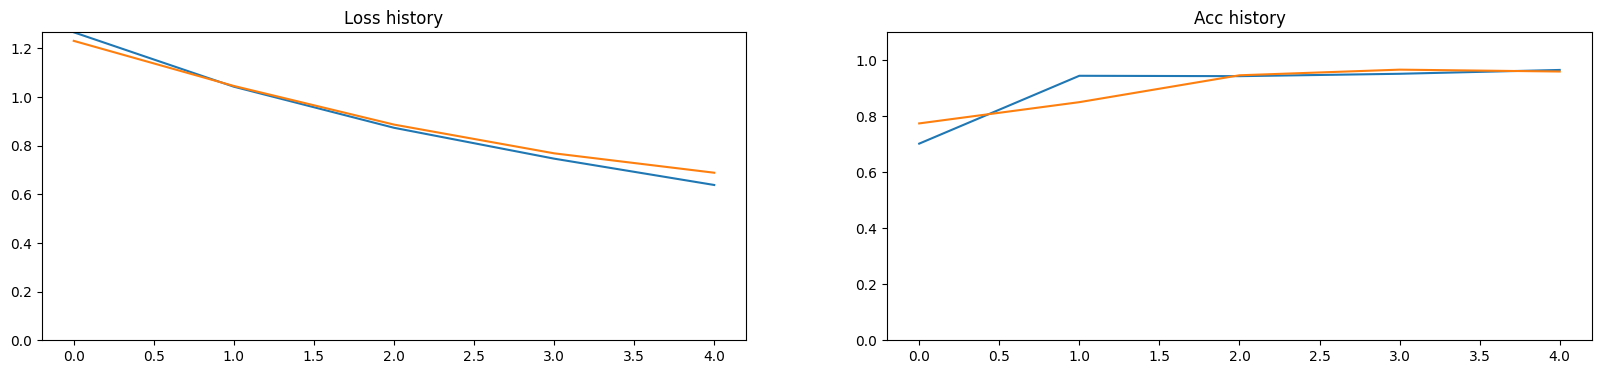

In [46]:
model.to(DEVICE)

train_epoch_acc = []
train_epoch_losses = []
valid_epoch_losses = []
valid_epoch_acc =[]
for epoch in range(5):

    loss_batch = []
    acc_batch  = []

    model.train()
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        preds = model(images)

        loss = criterion(preds, labels)


        loss_batch.append(loss.item())
        acc_batch.append(compute_batch_accuracy(preds, labels))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_epoch_losses.append(np.mean(loss_batch))
    train_epoch_acc.append(np.mean(acc_batch))

    model.eval()
    loss_batch = []
    acc_batch  = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            preds = model(images)

            loss = criterion(preds, labels)
            loss_batch.append(loss.item())
            acc_batch.append(compute_batch_accuracy(preds, labels))


    valid_epoch_losses.append(np.mean(loss_batch))
    valid_epoch_acc.append(np.mean(acc_batch))
    print(f'[Epoch {epoch:02d}] Train loss: {train_epoch_losses[-1]:.4f}, valid loss = {valid_epoch_losses[-1]:.4f} Train acc {train_epoch_acc[-1]:.4f} Valid acc {valid_epoch_acc[-1]:.4f}')

fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(train_epoch_losses)
ax[0].plot(valid_epoch_losses)
all_losses = train_epoch_losses + valid_epoch_losses
ax[0].set_ylim((0, max(all_losses)))
ax[0].set_title('Loss history')

ax[1].plot(train_epoch_acc)
ax[1].plot(valid_epoch_acc)
ax[1].set_ylim(0, 1.1)
ax[1].set_title('Acc history');

In [47]:
res = {'last_layer' : [train_epoch_losses, valid_epoch_losses, train_epoch_acc, valid_epoch_acc]}

In [48]:
images, labels = next(iter(valid_loader))
images

tensor([[[[0.5608, 0.4980, 0.5529,  ..., 0.6235, 0.6314, 0.6314],
          [0.5137, 0.5608, 0.5686,  ..., 0.6314, 0.6392, 0.6627],
          [0.5686, 0.5765, 0.6000,  ..., 0.6078, 0.6235, 0.6549],
          ...,
          [0.5529, 0.5686, 0.5765,  ..., 0.6078, 0.6314, 0.6392],
          [0.5373, 0.5451, 0.5686,  ..., 0.6235, 0.6235, 0.6157],
          [0.5373, 0.4980, 0.5765,  ..., 0.6549, 0.6627, 0.5922]],

         [[0.5765, 0.5137, 0.5686,  ..., 0.6392, 0.6471, 0.6471],
          [0.5294, 0.5765, 0.5843,  ..., 0.6471, 0.6549, 0.6784],
          [0.5843, 0.5922, 0.6157,  ..., 0.6235, 0.6392, 0.6706],
          ...,
          [0.5765, 0.6000, 0.5922,  ..., 0.6235, 0.6471, 0.6627],
          [0.5529, 0.5765, 0.6078,  ..., 0.6392, 0.6392, 0.6314],
          [0.5765, 0.5294, 0.6157,  ..., 0.6784, 0.6784, 0.6157]],

         [[0.5843, 0.5294, 0.5765,  ..., 0.6471, 0.6627, 0.6627],
          [0.5373, 0.5922, 0.6000,  ..., 0.6627, 0.6706, 0.6941],
          [0.6000, 0.6078, 0.6235,  ..., 0

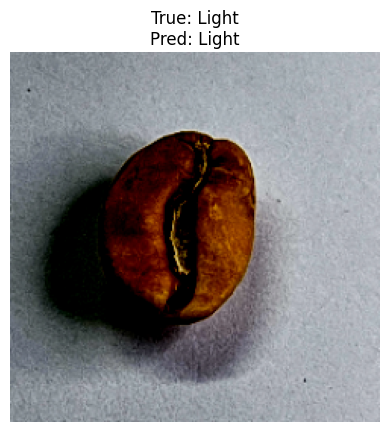

In [49]:
img, label = images[23].unsqueeze(0).to(DEVICE), labels[23]

model.eval()
with torch.no_grad():
    pred = model(img).argmax(dim=1).item()

img_show = img.cpu().squeeze().permute(1, 2, 0)
plt.imshow(img_show.clip(0, 1))
plt.title(f"True: {valid_loader.dataset.classes[label]}\nPred: {valid_loader.dataset.classes[pred]}")
plt.axis("off")
plt.show()

In [50]:
# trnsfrms = T.Compose(
#         [
#             T.Resize((244, 244)),
#             T.RandomRotation(45),
#             T.RandomHorizontalFlip(),
#             T.ToTensor(),
#             T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           
#    ])

In [51]:
# from PIL import Image
# img = Image.open('/Users/violettabahareva/ds-phase-2/08-nn/data/images.jpeg').convert('RGB')  # откроем и приведём к 3 каналам
# img = trnsfrms(img)  # применим трансформации
# img = img.unsqueeze(0)  # добавим размерность батча
# img = img.to(DEVICE)    # перенесём на нужное устройство

In [52]:
# model.eval()
# with torch.no_grad():
#     output = model(img)
#     pred_class = output.argmax(dim=1).item()

In [53]:
# classes = ['Dark', 'Green', 'Light', 'Medium']  # категории вашего датасета
# print(f"Предсказанный класс: {classes[pred_class]}")

In [54]:
torch.save(model.state_dict(), "cofee-beans_model.pt")

In [ ]:
PATH = "coffee-beans_model.pt" 
torch.save(model, PATH)